In [1]:
ALGORITHM = 'XG Boost'
ALGORITHM_DETAIL = 'random search'
VERSION = '03'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [2]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', XGBRegressor(seed=20))
])

In [3]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

confirm_colab = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB:
    from functions_20221018 import set_csv_directory, get_combined_dataset
    from functions_20221018 import add_supplements, tidy_dataset, feature_engineer

    set_csv_directory('final_split')

debug_mode = False

In [4]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

booleans = []
floats = ['bedrooms', 'bathrooms', 'nearestStation', 'latitude_deviation2', 'longitude_deviation2']
categories = ['tenure.tenureType']

columns = []
columns.extend(booleans)
columns.extend(floats)
columns.extend(categories)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'latitude_deviation2', 'longitude_deviation2', 'tenure.tenureType']
label ->  Price


In [5]:
filename = f'df_listings_v{VERSION}.csv'
remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
df_pathname_raw = f'../../data/source/{filename}'
df_pathname_tidy = f'../../data/final/{filename}'


def get_source_dataframe(rows=cutdown_rows, folder_prefix='../'):
    retrieval_type = None

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', remote_pathname)
    else:
        try:
            inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
            retrieval_type = 'tidy'
            print('loaded data from', df_pathname_tidy)
        except:
            try:
                inDF = pd.read_csv(df_pathname_raw, on_bad_lines='error', index_col=0)
                retrieval_type = 'raw'
                print(f'starting to get {retrieval_type} data...')
                print('loaded data from', df_pathname_raw)
                print(f'finished getting {retrieval_type} data!')
            except:
                print(f"WARNING: Failed to retrieved stored data for version {VERSION}, creating new source data.")
                retrieval_type = 'scratch'
                print(f'starting to get {retrieval_type} data...')
                inDF = get_combined_dataset(HOW='inner', early_duplicates=True, folder_prefix=folder_prefix)
                print(f'finished getting {retrieval_type} data!')

                print(f'starting to save {retrieval_type} data...')
                inDF.to_csv(df_pathname_raw)
                print(f'finished saving {retrieval_type} data!')

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    features = df[df.columns[2:]].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.9,
                                                                random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index



In [6]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    if retrieval_type != 'raw':
        df = add_supplements(df)
        print(f'starting to save {retrieval_type} data...')
        df.to_csv(df_pathname_raw)
        print(f'finished saving {retrieval_type} data!')
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

    print(f'starting to save {retrieval_type} data...')
    df.to_csv(df_pathname_tidy)
    print(f'finished saving {retrieval_type} data!')

print(df.shape)
df[:5]

df_orig.merge(df, how='inner', left_index=True, right_index=True)

print(df.index)

starting to get scratch data...
finished getting scratch data!
starting to save scratch data...
finished saving scratch data!
starting to save scratch data...
finished saving scratch data!
starting to save scratch data...
finished saving scratch data!
(51501, 7)
Index(['14520525', '27953107', '33593487', '35271294', '35429088', '44749111',
       '46204665', '49020666', '49036279', '49303873',
       ...
       '126173423', '126173600', '126175973', '126178769', '126179018',
       '126179672', '126180107', '126180704', '126180962', '126181118'],
      dtype='object', length=51501)


In [7]:
df

,Price,bedrooms,bathrooms,nearestStation,latitude_deviation2,longitude_deviation2,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,0.067288,0.141915,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,0.086728,0.417495,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,0.015482,0.273665,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,0.013094,0.075049,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,0.114368,0.076125,NaN
...,...,...,...,...,...,...,...
126179672,600000.0,3.0,2.0,0.545665,0.105492,0.009635,LEASEHOLD
126180107,419999.0,2.0,1.0,0.191407,0.068753,0.012141,LEASEHOLD
126180704,475000.0,2.0,1.0,0.308609,0.080479,0.076603,LEASEHOLD
126180962,450000.0,NaN,1.0,0.476935,0.129443,0.056872,FREEHOLD


In [8]:
df.isnull().sum()

Price                      0
bedrooms                1714
bathrooms               3149
nearestStation             0
latitude_deviation2       10
longitude_deviation2       0
tenure.tenureType       3352
dtype: int64

In [9]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 51501 entries, 14520525 to 126181118
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 51501 non-null  float64
 1   bedrooms              49787 non-null  float64
 2   bathrooms             48352 non-null  float64
 3   nearestStation        51501 non-null  float64
 4   latitude_deviation2   51491 non-null  float64
 5   longitude_deviation2  51501 non-null  float64
 6   tenure.tenureType     48149 non-null  object 
dtypes: float64(6), object(1)
memory usage: 5.2+ MB


,Price,bedrooms,bathrooms,nearestStation,latitude_deviation2,longitude_deviation2
count,51501.000000,49787.000000,48352.000000,51501.000000,5.149100e+04,5.150100e+04
mean,420845.464438,11.838693,1.177159,0.445829,6.952685e-02,1.391510e-01
std,109595.522981,2196.020360,0.410369,1.071443,4.656998e-02,7.234829e-01
min,100000.000000,1.000000,1.000000,0.000000,4.000000e-07,2.000000e-07
25%,335000.000000,1.000000,1.000000,0.224756,3.113350e-02,4.650480e-02
50%,425000.000000,2.000000,1.000000,0.364523,6.375360e-02,1.033192e-01
75%,500000.000000,3.000000,1.000000,0.558390,1.010514e-01,1.976652e-01
max,600000.000000,490000.000000,12.000000,192.431869,2.205226e-01,5.162385e+01


In [10]:
old_length = len(df)
#df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
#df = df[(df['location.longitude'] <= 10)]
#df = df[(df['longitude_deviation'] <= 1)]
df = df[(df['longitude_deviation2'] <= 1)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 51501 ==> 46877


,count,mean,std,min,25%,50%,75%,max
Price,46877.0,425062.235531,107229.476820,1.000000e+05,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46877.0,1.992448,0.828823,1.000000e+00,1.000000,2.000000,3.000000,7.000000
bathrooms,46877.0,1.182115,0.409907,1.000000e+00,1.000000,1.000000,1.000000,5.000000
nearestStation,46877.0,0.440245,0.350941,0.000000e+00,0.227201,0.367989,0.559762,16.168861
latitude_deviation2,46877.0,0.070195,0.046879,4.000000e-07,0.031454,0.064653,0.101922,0.220523
longitude_deviation2,46877.0,0.128441,0.101540,2.000000e-07,0.045578,0.102446,0.196934,0.433210


In [11]:
df.isna().sum()

Price                      0
bedrooms                   0
bathrooms                  0
nearestStation             0
latitude_deviation2        0
longitude_deviation2       0
tenure.tenureType       2744
dtype: int64

In [12]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46877 ==> 44133


,Price,bedrooms,bathrooms,nearestStation,latitude_deviation2,longitude_deviation2
count,44133.000000,44133.000000,44133.000000,44133.000000,4.413300e+04,4.413300e+04
mean,425217.021141,1.990959,1.181384,0.440008,7.010807e-02,1.279045e-01
std,107205.633151,0.827606,0.408961,0.350783,4.706236e-02,1.011763e-01
min,100000.000000,1.000000,1.000000,0.000000,4.000000e-07,2.000000e-07
25%,349950.000000,1.000000,1.000000,0.227574,3.105760e-02,4.530820e-02
50%,425000.000000,2.000000,1.000000,0.368397,6.445360e-02,1.020992e-01
75%,515000.000000,3.000000,1.000000,0.559534,1.019886e-01,1.959382e-01
max,600000.000000,7.000000,5.000000,16.168861,2.205226e-01,4.332102e-01


In [13]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(39719, 9) (4414, 9) (39719, 1) (4414, 1) (39719, 1) (4414, 1) (39719, 1) (4414, 1)


In [14]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [15]:
from time import time

#pipe.fit(X_train, y_train)

model = XGBRegressor()
#model.fit(X_train, y_train)
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [16]:

from sklearn.pipeline import Pipeline

# Best Score:  0.30582573121661794
# Best Score:  {'alpha': 10, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'selection': 'cyclic', 'tol': 0.001, 'warm_start': True}
# Best Score:  Lasso(alpha=10, tol=0.001, warm_start=True)
# Best Score:  138

options_block = {
    'objective': 'reg:squarederror',
    'base_score': None,
    #'booster': ['gbtree', 'gblinear', 'dart'],
    'callbacks': None,
    #'colsample_bylevel': [0.1, 0.3, 0.5, 0.7, 1],
    #'colsample_bynode': [0.1, 0.3, 0.5, 0.7, 1],
    #'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 1],
    'early_stopping_rounds': None,
    'enable_categorical': False,
    'eval_metric': None,
    #'gamma': [0,10,100,1000],
    # 'gpu_id': None,
    # 'grow_policy': None,
    # 'importance_type': None,
    # 'interaction_constraints': None,
    # 'learning_rate': None,
    # 'max_bin': None,
    # 'max_cat_to_onehot': None,
    #'max_delta_step': [1,2,5,10,30],
    #'max_depth': [1,3,6,10,30],
    #'max_leaves': None,
    #'min_child_weight': [1,2,5,10,30],
    ###'missing': nan,
    #'monotone_constraints': None,
    'n_estimators': 100,
    # 'n_jobs': None,
    # 'num_parallel_tree': None,
    # 'predictor': None,
    # 'random_state': None,
    # 'reg_alpha': [0,1,2,5,10,30],
    # 'reg_lambda': [1,2,5,10,30],
    # 'sampling_method': ['uniform','subsample','gradient_based'],
    # 'scale_pos_weight': [0.5,1,2],
    # 'subsample': [0.1, 0.3, 0.5, 0.7, 1],
    # 'tree_method': ['auto','approx','hist','gpu_hist','exact'],
    # 'validate_parameters': False,
    'verbosity': 1}

options_block = {
    'objective': 'reg:squarederror',
    # 'base_score': None,
    # 'booster': None,
    # 'callbacks': None,
    # 'colsample_bylevel': None,
    # 'colsample_bynode': None,
    # 'colsample_bytree': None,
    # 'early_stopping_rounds': None,
    # 'enable_categorical': False,
    # 'eval_metric': None,
    # 'gamma': None,
    # 'gpu_id': None,
    # 'grow_policy': None,
    # 'importance_type': None,
    # 'interaction_constraints': None,
    # 'learning_rate': None,
    # 'max_bin': None,
    # 'max_cat_to_onehot': None,
    # 'max_delta_step': None,
    # 'max_depth': None,
    'max_depth': [1, 3, 6, 10, 30],
    # 'max_leaves': None,
    # 'min_child_weight': None,
    ###'missing': nan,
    # 'monotone_constraints': None,
    'n_estimators': 100,
    # 'n_jobs': None,
    # 'num_parallel_tree': None,
    # 'predictor': None,
    # 'random_state': None,
    # 'reg_alpha': None,
    # 'reg_lambda': None,
    # 'sampling_method': None,
    # 'scale_pos_weight': None,
    # 'subsample': None,
    # 'tree_method': None,
    #'tree_method': ['auto', 'approx', 'hist', 'gpu_hist', 'exact'],
    'tree_method': ['auto', 'approx', 'hist', 'exact'],
    # 'validate_parameters': None,
    'verbosity': 1}

param_grid = {}
for each in options_block:
    if type(options_block[each]) == list:
        param_grid['model__' + each] = options_block[each]
    elif options_block[each] == None:
        #print (f'skipping {each} because value is {options_block[each]}')
        param_grid['model__' + each] = [options_block[each]]
    else:
        param_grid['model__' + each] = [options_block[each]]
#param_grid

cv = 3
n_jobs = 1
verbose = 1
refit = True

#grid = RandomizedSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)

# temp override
cv = 2

gs = RandomizedSearchCV(pipe, param_grid, cv=cv, n_jobs=n_jobs,
                        verbose=verbose, scoring=CROSS_VALIDATION_SCORING, refit=refit,
                        return_train_score=True, n_iter=30),
gs

grid_result = gs[0].fit(X_train, y_train)


Fitting 2 folds for each of 20 candidates, totalling 40 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 20 is smaller than n_iter=30. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [17]:
pipe = grid_result.best_estimator_
timings = []

t0 = time()
pipe.fit(X_train, y_train)
timings.append(time() - t0)

print(timings)
average_time = sum(timings) / len(timings)
print(average_time)

[3.3037590980529785]
3.3037590980529785


In [18]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}')


print_results(grid_result)
print('Best Index: ', grid_result.best_index_)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print('Best Model: ', grid_result.)
#print('Best Params: ', grid_result.best_params_)[out]
### Best Score:  0.4883436188936269
### Best Params:  {'alpha': 0.01}


BEST PARAMS: {'model__verbosity': 1, 'model__tree_method': 'approx', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 10}
0.351 (+/-0.006) for {'model__verbosity': 1, 'model__tree_method': 'auto', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.352 (+/-0.006) for {'model__verbosity': 1, 'model__tree_method': 'approx', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.352 (+/-0.006) for {'model__verbosity': 1, 'model__tree_method': 'hist', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.351 (+/-0.006) for {'model__verbosity': 1, 'model__tree_method': 'exact', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 1}
0.433 (+/-0.009) for {'model__verbosity': 1, 'model__tree_method': 'auto', 'model__objective': 'reg:squarederror', 'model__n_estimators': 100, 'model__max_depth': 3}
0.441 

In [19]:
y_pred = pipe.predict(X_test)

In [20]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------XG Boost----------
R square Accuracy 0.5745332385988913
Mean Absolute Error Accuracy 51147.26096652696
Mean Squared Error Accuracy 4733296553.824069
Root Mean Squared Error 68798.95750535809


In [21]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [22]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
122562932,550000.0,502939.84375,47060.15625,8.556392,9.357015
117089147,375000.0,347831.8125,27168.1875,7.24485,7.810725
123446663,475000.0,343590.125,131409.875,27.665237,38.246115
124867340,450000.0,496507.0625,46507.0625,10.334903,9.366848
121165313,325000.0,292704.84375,32295.15625,9.936971,11.033352
...,...,...,...,...,...
126115436,425000.0,405077.09375,19922.90625,4.687743,4.9183
123739259,235000.0,408315.6875,173315.6875,73.751356,42.446492
68620869,475000.0,514697.875,39697.875,8.357447,7.71285


In [23]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,latitude_deviation2,longitude_deviation2,tenure.tenureType
85446306,180000.0,474553.625,294553.625,163.640903,62.069619,180000.0,1.0,1.0,0.097806,0.088827,0.026093,LEASEHOLD
125100425,170000.0,441518.1875,271518.1875,159.716581,61.49649,170000.0,1.0,1.0,0.110385,0.044804,0.069016,LEASEHOLD
120813155,200000.0,504102.5625,304102.5625,152.051281,60.325534,200000.0,1.0,1.0,0.271953,0.081153,0.090803,SHARE_OF_FREEHOLD
124055675,240000.0,576761.9375,336761.9375,140.317474,58.388378,240000.0,1.0,1.0,0.283083,0.053422,0.131716,LEASEHOLD
124799795,210000.0,442712.34375,232712.34375,110.815402,52.565136,210000.0,2.0,1.0,0.279714,0.036522,0.273425,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...
123165680,565000.0,565057.8125,57.8125,0.010232,0.010231,565000.0,3.0,2.0,0.103215,0.052116,0.074984,SHARE_OF_FREEHOLD
85421026,285000.0,284989.09375,10.90625,0.003827,0.003827,285000.0,1.0,1.0,0.869301,0.111108,0.191408,LEASEHOLD
96618652,500000.0,500012.4375,12.4375,0.002488,0.002487,500000.0,3.0,1.0,0.671215,0.085730,0.141262,FREEHOLD
120769481,265000.0,264995.0,5.0,0.001887,0.001887,265000.0,2.0,1.0,0.808265,0.046946,0.031194,LEASEHOLD


In [24]:
score = pipe.score(X_test, y_test)
score

0.5745332385988913

In [25]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.5745332385988913

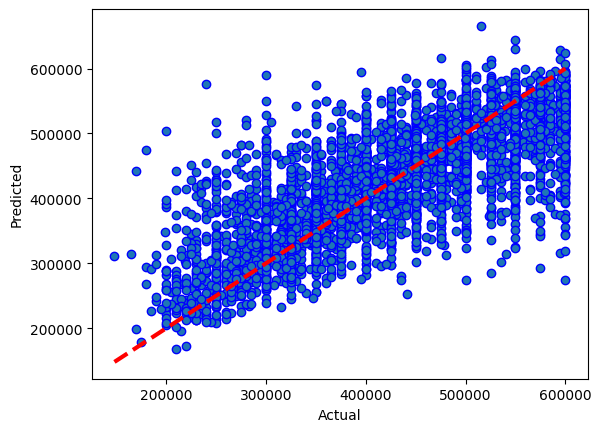

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [27]:
if False:
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            #return pd.Series({**params, **d})
            return pd.Series({**params, **d, **{'params_full': str(params)}})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]


    import seaborn as sns

    score_summary = score_summary(self=gs, sort_by='max_score')

In [28]:

if False:
    #sns.set(rc={"figure.figsize": (10, 10)})
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    #total_graphs = len(score_summary)
    # max_horizontal = 4
    # index2 = 0
    # resultant_rows = math.ceil(total_graphs / max_horizontal)
    # #subplots_adjust()
    #
    # #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    best_estimator = score_summary.iloc[0]
    worst_estimator = score_summary.iloc[-1]

    name_best = best_estimator["estimator"]
    params_str = best_estimator["params_full"]
    params_best = ast.literal_eval(params_str)

    name_worst = worst_estimator["estimator"]
    params_str = worst_estimator["params_full"]
    params_worst = ast.literal_eval(params_str)

    KNeighborsRegressor().set_params()

    best_pipe = make_pipe(name_best)
    worst_pipe = make_pipe(name_worst)

    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test, y=best_pipe.set_params(**params_best).fit(X_train, y_train).predict(X_test), ax=axes[0],
                    s=100).set(
        title=f'"BEST" model: {name_best} \n{params_best}')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test, y=worst_pipe.set_params(**params_worst).fit(X_train, y_train).predict(X_test), ax=axes[1],
                    s=100).set(
        title=f'"WORST" model: {name_worst} \n{params_worst}')

    sns.scatterplot(x=y_test, y=worst_pipe.set_params(**params_worst).fit(X_train, y_train).predict(X_test), ax=axes[2],
                    s=100, color='orange')
    sns.scatterplot(x=y_test, y=best_pipe.set_params(**params_best).fit(X_train, y_train).predict(X_test), ax=axes[2],
                    s=100, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')

    fig.tight_layout()
    plt.show()

if False:
    max_horizontal = 3

    #sns.set()
    #sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
    sns.set(rc={"figure.figsize": (20, 20)})
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    total_graphs = len(score_summary)
    index2 = 0
    resultant_rows = math.ceil(total_graphs / max_horizontal)
    #subplots_adjust()

    #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
    fig, axes = plt.subplots(nrows=2, ncols=max_horizontal, figsize=(15, 10))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    for (key, next_estimator), index in zip(score_summary.iterrows(), range(total_graphs)):
        if index % (max_horizontal * 2) == 0 and index != 0:
            index2 = 0
            fig.tight_layout()
            plt.show()
            #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
            fig, axes = plt.subplots(nrows=2, ncols=max_horizontal, figsize=(15, 10))

        name_next = next_estimator["estimator"]
        params_str = next_estimator["params_full"]
        params_next = ast.literal_eval(params_str)
        #print("next", params_next)

        if 'noscale' in name_next:
            pipe = Pipeline(steps=[
                ('preprocessor', features_noscale_preprocessor),  # preprocess features
                ('estimator', models_and_params[name_next]["model"]),
            ])  # start the training
        else:
            pipe = Pipeline(steps=[
                ('preprocessor', features_preprocessor),
                ('estimator', models_and_params[name_next]["model"]),  # preprocess features
            ])  # start the training

        # 0 ==> 0,0
        # 1 ==> 0,1
        # 2 ==> 1,0
        x_coor = index2 // max_horizontal
        y_coor = index2 % max_horizontal

        coordinates = axes[x_coor][y_coor]
        #sns.lineplot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], hue='red', lw=3)
        sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=coordinates, color='red')
        sns.scatterplot(x=y_test, y=pipe.set_params(**params_next).fit(X_train, y_train).predict(X_test),
                        ax=coordinates, s=100).set(
            title=f'({index}) {"BEST" if index == 0 else "next"} model: {name_next} \n{params_next}')
        #if index == 11: break
        index2 += 1

    fig.tight_layout()
    plt.show()

In [29]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': grid_result.best_params_
}
import json


def get_results():
    results_filename = '../../results/results.json'

    with open(results_filename) as f:
        raw_audit = f.read()
    results_json = json.loads(raw_audit)
    return results_json


def update_results(saved_results_json, new_results):
    key = f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()
    try:
        first_run_date = str(datetime.now())
        first_run_date = saved_results_json[key]['date']
        first_run_date = saved_results_json[key]['first run']
    except:
        pass

    try:
        max_score = -1000
        max_params = 'NOT APPLICABLE'
        max_score = saved_results_json[key]['Score']
        max_params = saved_results_json[key]['params']
        max_score = saved_results_json[key]['max score']
        max_params = saved_results_json[key]['max params']
    except:
        pass

    results['first run'] = first_run_date
    if key not in saved_results_json:
        new_results['max params'] = new_results['params']
        new_results['max score'] = new_results['Score']
        new_results['suboptimal'] = 'pending'
    elif max_score > saved_results_json[key]['Score']:
        new_results['suboptimal'] = 'suboptimal'
    elif max_score == saved_results_json[key]['Score']:
        if saved_results_json[key]['params'] != new_results['params']:
            new_results['max params'] = 'MULTIPLE PARAM OPTIONS'
        else:
            new_results['max params'] = saved_results_json[key]['params']
            new_results['max score'] = saved_results_json[key]['Score']
            new_results['suboptimal'] = 'pending'
    else:
        new_results['max params'] = saved_results_json[key]['params']
        new_results['max score'] = saved_results_json[key]['Score']
        new_results['suboptimal'] = 'pending'

    saved_results_json[key] = new_results

    results_filename = '../../results/results.json'
    with open(results_filename, 'w') as file:
        file.write(json.dumps(saved_results_json, indent=4))


if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results)

results

{'Score': 0.5745332385988913,
 'R square Accuracy': 0.5745332385988913,
 'Mean Absolute Error Accuracy': 51147.26096652696,
 'Mean Squared Error Accuracy': 4733296553.824069,
 'Root Mean Squared Error': 68798.95750535809,
 'Training Time': 3.3037590980529785,
 'random_state': 101,
 'date': '2022-10-18 19:31:55.115003',
 'params': {'model__verbosity': 1,
  'model__tree_method': 'approx',
  'model__objective': 'reg:squarederror',
  'model__n_estimators': 100,
  'model__max_depth': 10},
 'first run': '2022-10-18 19:16:54.647950',
 'max params': {'model__verbosity': 1,
  'model__tree_method': 'approx',
  'model__objective': 'reg:squarederror',
  'model__n_estimators': 100,
  'model__max_depth': 10},
 'max score': 0.5820713372252954,
 'suboptimal': 'pending'}